In [11]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import sympy code for gauss lobatto nodes
from sympy.core import S, Dummy, pi
from sympy.functions.combinatorial.factorials import factorial
from sympy.functions.elementary.trigonometric import sin, cos
from sympy.functions.elementary.miscellaneous import sqrt
from sympy.functions.special.gamma_functions import gamma
from sympy.polys.orthopolys import (legendre_poly, laguerre_poly,
                                    hermite_poly, jacobi_poly)
from sympy.polys.rootoftools import RootOf
from sympy.core.compatibility import range

In [3]:
# Parameters
num_grdpts = 3
num_elems = num_grdpts - 1
num_nodes = 15

In [4]:
# Calls from Input Control
grdpts = np.array([0.0, 0.3, 1.0])
degree_vec = np.array([12, 12])

In [5]:
def gauss_lobatto(n, n_digits):
    r"""
    Computes the Gauss-Lobatto quadrature [1]_ points and weights.

    The Gauss-Lobatto quadrature approximates the integral:

    .. math::
        \int_{-1}^1 f(x)\,dx \approx \sum_{i=1}^n w_i f(x_i)

    The nodes `x_i` of an order `n` quadrature rule are the roots of `P'_(n-1)`
    and the weights `w_i` are given by:

    .. math::
        &w_i = \frac{2}{n(n-1) \left[P_{n-1}(x_i)\right]^2},\quad x\neq\pm 1\\
        &w_i = \frac{2}{n(n-1)},\quad x=\pm 1

    Parameters
    ==========

    n : the order of quadrature

    n_digits : number of significant digits of the points and weights to return

    Returns
    =======

    (x, w) : the ``x`` and ``w`` are lists of points and weights as Floats.
             The points `x_i` and weights `w_i` are returned as ``(x, w)``
             tuple of lists.

    Examples
    ========

    >>> from sympy.integrals.quadrature import gauss_lobatto
    >>> x, w = gauss_lobatto(3, 5)
    >>> x
    [-1, 0, 1]
    >>> w
    [0.33333, 1.3333, 0.33333]
    >>> x, w = gauss_lobatto(4, 5)
    >>> x
    [-1, -0.44721, 0.44721, 1]
    >>> w
    [0.16667, 0.83333, 0.83333, 0.16667]

    See Also
    ========

    gauss_legendre,gauss_laguerre, gauss_gen_laguerre, gauss_hermite, gauss_chebyshev_t, gauss_chebyshev_u, gauss_jacobi

    References
    ==========

    .. [1] http://en.wikipedia.org/wiki/Gaussian_quadrature#Gauss.E2.80.93Lobatto_rules
    .. [2] http://people.math.sfu.ca/~cbm/aands/page_888.htm
    TAKEN FROM SYMPY
    """
    x = Dummy("x")
    p = legendre_poly(n-1, x, polys=True)
    pd = p.diff(x)
    xi = []
    w = []
    for r in pd.real_roots():
        if isinstance(r, RootOf):
            r = r.eval_rational(S(1)/10**(n_digits+2))
        xi.append(r.n(n_digits))
        w.append((2/(n*(n-1) * p.subs(x, r)**2)).n(n_digits))

    xi.insert(0, -1)
    xi.append(1)
    w.insert(0, (S(2)/(n*(n-1))).n(n_digits))
    w.append((S(2)/(n*(n-1))).n(n_digits))
    return xi, w

In [42]:
def leg_eval(q,x):
    '''
    Evaluate Legendre polynomials of up to degree q at point x
    '''
    if q == 0:
        return np.array([1])
    elif q == 1:
        return np.array([1,x])
    else:
        leg_arr = np.zeros([q])
        leg_arr[0] = 1
        leg_arr[1] = x
        
        # Recursion relation for higher order Leg. polynomials
        for i in range(1,q-1):
            leg_arr[i+1] = ((2*i+1)*x*leg_arr[i] - i*leg_arr[i-1])/(i+1)
        return np.array(leg_arr)

In [6]:
def f(x):
    return np.exp((x-2)**2/2)

In [53]:
for i in np.arange(num_elems):
    # Element characteristics
    lt_endpt = grdpts[i]
    rt_endpt = grdpts[i+1]
    q = degree_vec[i]
    a = np.zeros([q])
    viz_a = np.zeros([q,q])
    
    # --- Start building weights for the approximation --- ###
    # Acquire Gauss-Lobatto (LGL) nodes
    leg_nodes, leg_weights = gauss_lobatto(q,16)
    leg_nodes = np.array(leg_nodes, dtype=float)
    
    # Evaluate function on nodes mapped onto the x-domain
    x_nodes = 0.5 * (leg_nodes*(rt_endpt - lt_endpt) + (rt_endpt + lt_endpt))
    fcn_vals = np.zeros([q])
    for j in range(len(fcn_vals)):     # Should be vectorized, but is broken
        fcn_vals[j] = f(x_nodes[j])
    
    # Build integral approximation (the RHS of the problem statement) by node
    for j in range(q):
        leg_eval_arr = leg_eval(q, leg_nodes[j])       # Returns array (len q) of lgdr evaluations at a node
#         if i == 0:
#             print(j, leg_eval_arr)
        a = a + leg_eval_arr*leg_weights[j]*fcn_vals[j]
                # Note: leg_eval_arr and leg_weights are evaluated on r = [-1,1]
                #       fcn_vals is evaluated on x = [xl, xr]
        viz_a[j,:] = a.copy()
    
    # Rescale a (See Orthogonality on Wiki for Ldgr poly)
    for j in range(len(a)):
        a[j] = 0.5*(2*j + 1)*a[j]
        
        
    ### --- Start Approximation Calculation --- ###
    sample_nodes = np.linspace(lt_endpt, rt_endpt, num_nodes)
    
#     print(fcn_array)

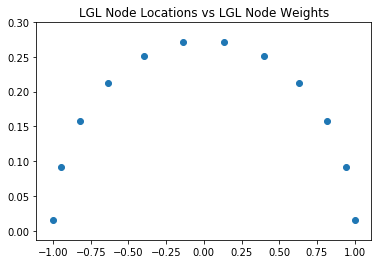

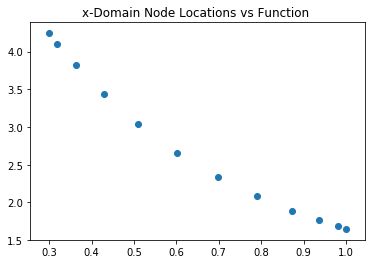

In [18]:
plt.figure()
plt.scatter(leg_nodes, leg_weights)
plt.title('LGL Node Locations vs LGL Node Weights')
plt.show()

plt.figure()
plt.scatter(x_nodes, fcn_vals)
plt.title('x-Domain Node Locations vs Function')
plt.show()

plt.figure()
plt.scatter()

12.0
